# Test Harness Demo

In [1]:
# Imports
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.random_forest_regression import random_forest_regression
from harness.th_model_instances.hamed_models.rocklin_models import rocklins_linear_regression

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# Read in the data (Rocklin Dataset)
protein_data = pd.read_csv('rocklin_dataset_simplified.csv', comment='#', low_memory=False)

In [4]:
# Let's see what the data looks like
protein_data.head()

,dataset,name,topology,sequence,dssp,description,assay_library,chip_name,stabilityscore,stabilityscore_calibrated,stabilityscore_cnn,stabilityscore_cnn_calibrated,AlaCount,T1_absq,T1_netq,Tend_absq,Tend_netq,Tminus1_absq,Tminus1_netq,abego_res_profile,abego_res_profile_penalty,avg_all_frags,avg_best_frag,bb,buns_bb_heavy,buns_nonheavy,buns_sc_heavy,buried_minus_exposed,buried_np,buried_np_AFILMVWY,buried_np_AFILMVWY_per_res,buried_np_per_res,buried_over_exposed,chymo_cut_sites,chymo_with_LM_cut_sites,contact_all,contact_core_SASA,contact_core_SCN,contig_not_hp_avg,contig_not_hp_avg_norm,contig_not_hp_internal_max,contig_not_hp_max,degree,dslf_fa13,entropy,exposed_hydrophobics,exposed_np_AFILMVWY,exposed_polars,exposed_total,fa_atr,fa_atr_per_res,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,fa_intra_sol_xover4,fa_rep,fa_rep_per_res,fa_sol,frac_helix,frac_loop,frac_sheet,fxn_exposed_is_np,hbond_bb_sc,hbond_lr_bb,hbond_lr_bb_per_sheet,hbond_sc,hbond_sr_bb,hbond_sr_bb_per_helix,helix_sc,holes,hphob_sc_contacts,hphob_sc_degree,hxl_tors,hydrophobicity,largest_hphob_cluster,lk_ball,lk_ball_bridge,lk_ball_bridge_uncpl,lk_ball_iso,loop_sc,mismatch_probability,n_charged,n_hphob_clusters,n_hydrophobic,n_hydrophobic_noA,n_polar_core,n_res,nearest_chymo_cut_to_Cterm,nearest_chymo_cut_to_Nterm,nearest_chymo_cut_to_term,nearest_tryp_cut_to_Cterm,nearest_tryp_cut_to_Nterm,nearest_tryp_cut_to_term,net_atr_net_sol_per_res,net_atr_per_res,net_sol_per_res,netcharge,nres,nres_helix,nres_loop,nres_sheet,omega,one_core_each,p_aa_pp,pack,percent_core_SASA,percent_core_SCN,pro_close,rama_prepro,ref,res_count_core_SASA,res_count_core_SCN,score_per_res,ss_contributes_core,ss_sc,sum_best_frags,total_score,tryp_cut_sites,two_core_each,worst6frags,worstfrag
0,Rocklin,HEEH_rd2_0365,HEEH,PQEAEDRARKIKKKNLTTVTIGNYELRYTNPEELARAAKKLLI,LHHHHHHHHHHHHLLLLEEEELLEEEELLLHHHHHHHHHHHHL,data/Rocklin_2017_Science/HEEH_rd2_0365,2.0,NaN,-0.08,-0.08,-0.192347,-0.192347,5.0,3.0,-3.0,6.0,6.0,3.0,3.0,0.266,-0.039,1.291,0.286,-0.136,0.0,0.0,0.0,3537.971,5251.985,2109.095,49.049,122.139,3.064,2,4.5,120.0,120.0,120.0,3.556,0.992,5,10,9.605,0.0,0.0,1714.015,417.905,1719.448,3433.463,-225.818,-5.252,2.330,33.529,39.321,-75.347,-14.851,-6.713,13.402,10.412,51.974,1.209,178.431,0.558,0.256,0.186,0.499,-1.279,-5.867,-0.733,-9.983,-26.451,-1.102,0.764,0.317,12,1.091,14.410,651.0,10,108.047,0.142,0.538,252.770,0.790,0.178,16.0,2,16,11,0.0,43,16,24,16,4,7,4,-1.646,-4.043,2.397,4.0,43.0,24,11,8,2.898,1.0,-12.700,0.636,0.116,0.186,0.53,-10.754,-24.808,5.0,8.0,-2.374,1.0,0.773,10.027,-102.092,10,0.5,3.607,0.831
1,Rocklin,EEHEE_rd2_0259,EEHEE,TTLEVNGEKYTFTSTTEAQEFAKKFGATTIEVRGTTVRVTR,LEEEELLEEEELLLHHHHHHHHHHHLLLEEEEELLEEEEEL,data/Rocklin_2017_Science/EEHEE_rd2_0259,2.0,NaN,-0.05,-0.05,-0.334317,-0.334317,3.0,1.0,-1.0,3.0,3.0,2.0,2.0,0.303,-0.043,1.742,0.291,-0.474,2.0,2.0,0.0,3363.633,4849.817,1902.121,46.393,118.288,3.263,4,4.5,123.0,123.0,123.0,2.818,0.756,8,8,9.585,0.0,0.0,1486.183,230.879,1454.321,2940.505,-196.277,-4.787,1.607,23.157,36.095,-82.119,-12.672,-8.046,10.204,7.882,40.112,0.978,143.187,0.268,0.293,0.439,0.505,-2.512,-19.430,-1.079,-7.067,-15.573,-1.416,0.744,1.791,14,1.400,49.204,820.0,10,97.114,0.530,2.231,218.320,0.744,0.270,11.0,1,13,10,1.0,41,17,10,10,1,9,1,-2.319,-3.809,1.489,1.0,41.0,11,12,18,5.245,0.6,-16.972,0.631,0.098,0.146,0.00,-1.221,-14.858,4.0,6.0,-2.115,1.0,0.744,9.606,-86.716,6,0.4,3.131,0.647
2,Rocklin,EEHEE_rd1_0176,EEHEE,PRVRSNGQTYQATSREEARKIAKKANGKTVEETNDEFRVKK,LEEEELLEEEELLLHHHHHHHHHHHLLLEEEEELLEEEEEL,data/Rocklin_2017_Science/EEHEE_rd1_0176,1.0,NaN,0.54,0.54,0.563990,0.563990,4.0,3.0,-1.0,5.0,3.0,2.0,2.0,0.272,-0.041,1.886,0.525,-0.424,0.0,0.0,0.0,3324.705,4756.853,1331.209,32.469,116.021,3.321,2,2.0,93.0,93.0,93.0,5.000,0.854,10,10,9.341,0.0,0.0,1432.147,152.791,1770.037,3202.184,-202.289,-4.934,2.444,35.878,43.125,-83.496,-13.249,-11.714,8.537,10.223,45.564,1.111,175.014,0.268,0.293,0.439,0.447,-3.707,-

## Some Context

In the Protein Design challenge problem, one of the goals is to be able to predict experimental protein stability from computational features (often derived from or generated by Rosetta software). Protein stability is quantified through a "stability score" that the domain experts have created. 

Over the course of this challenge problem, some methods have been created to make stability scores more accurate, and this is why you see four stability score columns in the data. The latest/best version that should be used is "stabilityscore_cnn_calibrated".

Proteins with stability scores greater than 1 are considered "stable", while proteins with stability scores less than or equal to 1 are considered "unstable". Thus there are two prediction tasks that are possible:
1. Regression Task: prediction of stability score
2. Classification Task: predicting if a protein is "stable" or "unstable"

For the regression task, the column named "stabilityscore_cnn_calibrated" can be used as the column to predict.
For the classification task, a new column called "stabilityscore_cnn_calibrated_2classes" is created in the next coding block. This column just assigns a value of True or False depending on if the "stabilityscore_cnn_calibrated" column is larger than 1.

In [5]:
protein_data.insert(12, "stabilityscore_cnn_calibrated_2classes", protein_data['stabilityscore_cnn_calibrated'] > 1)

In [6]:
# Set prediction column variables here:
regression_prediction_col = "stabilityscore_cnn_calibrated"
classification_prediction_col = "stabilityscore_cnn_calibrated_2classes"

# For this dataset, all the feature columns are after the stabilityscore columns, starting with "AlaCount"
# So we can use that information to obtain all the feature_columns. There should be 113 feature columns.
feature_columns = protein_data.columns.values.tolist()[13:]

print(len(feature_columns))

113


In [7]:
protein_data.head()

,dataset,name,topology,sequence,dssp,description,assay_library,chip_name,stabilityscore,stabilityscore_calibrated,stabilityscore_cnn,stabilityscore_cnn_calibrated,stabilityscore_cnn_calibrated_2classes,AlaCount,T1_absq,T1_netq,Tend_absq,Tend_netq,Tminus1_absq,Tminus1_netq,abego_res_profile,abego_res_profile_penalty,avg_all_frags,avg_best_frag,bb,buns_bb_heavy,buns_nonheavy,buns_sc_heavy,buried_minus_exposed,buried_np,buried_np_AFILMVWY,buried_np_AFILMVWY_per_res,buried_np_per_res,buried_over_exposed,chymo_cut_sites,chymo_with_LM_cut_sites,contact_all,contact_core_SASA,contact_core_SCN,contig_not_hp_avg,contig_not_hp_avg_norm,contig_not_hp_internal_max,contig_not_hp_max,degree,dslf_fa13,entropy,exposed_hydrophobics,exposed_np_AFILMVWY,exposed_polars,exposed_total,fa_atr,fa_atr_per_res,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,fa_intra_sol_xover4,fa_rep,fa_rep_per_res,fa_sol,frac_helix,frac_loop,frac_sheet,fxn_exposed_is_np,hbond_bb_sc,hbond_lr_bb,hbond_lr_bb_per_sheet,hbond_sc,hbond_sr_bb,hbond_sr_bb_per_helix,helix_sc,holes,hphob_sc_contacts,hphob_sc_degree,hxl_tors,hydrophobicity,largest_hphob_cluster,lk_ball,lk_ball_bridge,lk_ball_bridge_uncpl,lk_ball_iso,loop_sc,mismatch_probability,n_charged,n_hphob_clusters,n_hydrophobic,n_hydrophobic_noA,n_polar_core,n_res,nearest_chymo_cut_to_Cterm,nearest_chymo_cut_to_Nterm,nearest_chymo_cut_to_term,nearest_tryp_cut_to_Cterm,nearest_tryp_cut_to_Nterm,nearest_tryp_cut_to_term,net_atr_net_sol_per_res,net_atr_per_res,net_sol_per_res,netcharge,nres,nres_helix,nres_loop,nres_sheet,omega,one_core_each,p_aa_pp,pack,percent_core_SASA,percent_core_SCN,pro_close,rama_prepro,ref,res_count_core_SASA,res_count_core_SCN,score_per_res,ss_contributes_core,ss_sc,sum_best_frags,total_score,tryp_cut_sites,two_core_each,worst6frags,worstfrag
0,Rocklin,HEEH_rd2_0365,HEEH,PQEAEDRARKIKKKNLTTVTIGNYELRYTNPEELARAAKKLLI,LHHHHHHHHHHHHLLLLEEEELLEEEELLLHHHHHHHHHHHHL,data/Rocklin_2017_Science/HEEH_rd2_0365,2.0,NaN,-0.08,-0.08,-0.192347,-0.192347,False,5.0,3.0,-3.0,6.0,6.0,3.0,3.0,0.266,-0.039,1.291,0.286,-0.136,0.0,0.0,0.0,3537.971,5251.985,2109.095,49.049,122.139,3.064,2,4.5,120.0,120.0,120.0,3.556,0.992,5,10,9.605,0.0,0.0,1714.015,417.905,1719.448,3433.463,-225.818,-5.252,2.330,33.529,39.321,-75.347,-14.851,-6.713,13.402,10.412,51.974,1.209,178.431,0.558,0.256,0.186,0.499,-1.279,-5.867,-0.733,-9.983,-26.451,-1.102,0.764,0.317,12,1.091,14.410,651.0,10,108.047,0.142,0.538,252.770,0.790,0.178,16.0,2,16,11,0.0,43,16,24,16,4,7,4,-1.646,-4.043,2.397,4.0,43.0,24,11,8,2.898,1.0,-12.700,0.636,0.116,0.186,0.53,-10.754,-24.808,5.0,8.0,-2.374,1.0,0.773,10.027,-102.092,10,0.5,3.607,0.831
1,Rocklin,EEHEE_rd2_0259,EEHEE,TTLEVNGEKYTFTSTTEAQEFAKKFGATTIEVRGTTVRVTR,LEEEELLEEEELLLHHHHHHHHHHHLLLEEEEELLEEEEEL,data/Rocklin_2017_Science/EEHEE_rd2_0259,2.0,NaN,-0.05,-0.05,-0.334317,-0.334317,False,3.0,1.0,-1.0,3.0,3.0,2.0,2.0,0.303,-0.043,1.742,0.291,-0.474,2.0,2.0,0.0,3363.633,4849.817,1902.121,46.393,118.288,3.263,4,4.5,123.0,123.0,123.0,2.818,0.756,8,8,9.585,0.0,0.0,1486.183,230.879,1454.321,2940.505,-196.277,-4.787,1.607,23.157,36.095,-82.119,-12.672,-8.046,10.204,7.882,40.112,0.978,143.187,0.268,0.293,0.439,0.505,-2.512,-19.430,-1.079,-7.067,-15.573,-1.416,0.744,1.791,14,1.400,49.204,820.0,10,97.114,0.530,2.231,218.320,0.744,0.270,11.0,1,13,10,1.0,41,17,10,10,1,9,1,-2.319,-3.809,1.489,1.0,41.0,11,12,18,5.245,0.6,-16.972,0.631,0.098,0.146,0.00,-1.221,-14.858,4.0,6.0,-2.115,1.0,0.744,9.606,-86.716,6,0.4,3.131,0.647
2,Rocklin,EEHEE_rd1_0176,EEHEE,PRVRSNGQTYQATSREEARKIAKKANGKTVEETNDEFRVKK,LEEEELLEEEELLLHHHHHHHHHHHLLLEEEEELLEEEEEL,data/Rocklin_2017_Science/EEHEE_rd1_0176,1.0,NaN,0.54,0.54,0.563990,0.563990,False,4.0,3.0,-1.0,5.0,3.0,2.0,2.0,0.272,-0.041,1.886,0.525,-0.424,0.0,0.0,0.0,3324.705,4756.853,1331.209,32.469,116.021,3.321,2,2.0,93.0,93.0,93.0,5.000,0.854,10,10,9.341,0.0,0.0,1432.147,152.791,1770.037,3202.184,-202.289,-4.934,2.444,35.878,43.125,-83.496,-13.249,-11.714,8.537,10.

In [8]:
# Create training and testing splits, stratified on topology and dataset
train_df, test_df = train_test_split(protein_data, test_size=0.2, random_state=5,
                                     stratify=protein_data[['topology', 'dataset']])
print(train_df.shape)
print(test_df.shape)

(12927, 126)
(3232, 126)


## Begin Test Harness Usage

In the next code block, I set the path to the directory in which I want my results to go by setting the output_location argument. When the Test Harness runs, it will create a "test_harness_results" folder inside of output_location and place all results inside the "test_harness_results" folder. If the "test_harness_results" folder already exists, then previous results/leaderboards will be updated. In this demo, the output_location has been set to the current folder.

In [9]:
current_path = os.getcwd()
th = TestHarness(output_location=current_path)

print("created TestHarness object with output_location:\n {}".format(current_path))
print()


created TestHarness object with output_location:
 /Users/he/PycharmProjects/SD2/test-harness/example_scripts/Data_Sharing_Demo



Add description of next code block (custom run) here. Might want to include descriptions of each argument as well.

In [10]:
# custom run with a custom train/test split
th.run_custom(function_that_returns_TH_model=random_forest_classification, dict_of_function_parameters={}, 
              training_data=train_df, testing_data=test_df,
              data_and_split_description="example custom run on the Rocklin dataset",
              cols_to_predict=classification_prediction_col, 
              feature_cols_to_use=feature_columns,
              index_cols=["dataset", "name"], 
              normalize=True, feature_cols_to_normalize=feature_columns, 
              feature_extraction=False, predict_untested_data=False)

----------------------------------------------------------------------------------------------------
Starting run at time 16:20:33
Normalizing training and testing splits...
Starting Classification training...
Training time was: 6.99 seconds
Testing time was: 0.54 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description                        Column Predicted Num Features Used                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  5Wx1y9y11AGB8  2019-07-29  16:20:33  random_forest_classification  Hamed        2           0.882     0.85               0.931      0.785              0.7       0.622      0.8     12927            3232            Random Fo

Add description of next code block (LOO run) here. Might want to include descriptions of each argument as well.

### Leave-One-Out Runs

The leave-one-out method will create splits of data based on the passed-in grouping. The model will then be run on each created split.

In [11]:
# Model = Baseline Linear Regressor:
th.run_leave_one_out(function_that_returns_TH_model=rocklins_linear_regression, dict_of_function_parameters={}, 
                     data=protein_data, data_description="Rocklin dataset",
                     grouping=["dataset", "topology"], grouping_description="dataset and topology", 
                     cols_to_predict=regression_prediction_col,
                     feature_cols_to_use=feature_columns, 
                     index_cols=["dataset", "name"], 
                     normalize=True, feature_cols_to_normalize=feature_columns, 
                     feature_extraction=False)

Creating test split based on group_index 0, defined by: {'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}
Number of samples in train split: (10912, 127)
Number of samples in test split: (5247, 127)
----------------------------------------------------------------------------------------------------
Starting run at time 16:20:46
Normalizing training and testing splits...
Starting Regression training...
Training time was: 0.48 seconds
Testing time was: 0.01 seconds

          Run ID        Date      Time Model Name Model Author  R-Squared   RMSE Samples In Train Samples In Test                                  Model Description               Column Predicted Num Features Used Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted Leave-One-Out ID                                                           Test Group
0  55VaBmN9958ly  2019-07-29  16:20:46  __init__   Hamed        0.275      0.526  10912            5247  

In [12]:
# Model = Random Forest Regressor:
th.run_leave_one_out(function_that_returns_TH_model=random_forest_regression, dict_of_function_parameters={}, 
                     data=protein_data, data_description="Rocklin dataset",
                     grouping=["dataset", "topology"], grouping_description="dataset and topology", 
                     cols_to_predict=regression_prediction_col,
                     feature_cols_to_use=feature_columns, 
                     index_cols=["dataset", "name"], 
                     normalize=True, feature_cols_to_normalize=feature_columns, 
                     feature_extraction=False)

Creating test split based on group_index 0, defined by: {'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}
Number of samples in train split: (10912, 127)
Number of samples in test split: (5247, 127)
----------------------------------------------------------------------------------------------------
Starting run at time 16:20:55
Normalizing training and testing splits...
Starting Regression training...
Training time was: 49.13 seconds
Testing time was: 0.22 seconds

          Run ID        Date      Time Model Name Model Author  R-Squared   RMSE Samples In Train Samples In Test                                                                                                                     Model Description               Column Predicted Num Features Used Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted Leave-One-Out ID                                                           Test Group
0  6qG5lbJ9OGNEY  201

In [13]:
%matplotlib inline

In [14]:
def vis_boxplot(data_df, x_colname, y_colname, title, x_label, y_label, color_by_col, hue_order=None, palette="colorblind",
                legend=True, legend_title=None, legend_location="lower right", legend_dict=None, sort=True, rotate_x_ticks=90,
                x_dict=None):
    sns.set(rc={'figure.figsize': (22, 10)})
    if sort is True:
        data_df.sort_values(by=y_colname, inplace=True, ascending=False)
    if x_dict:
        x_axis_order = x_dict.values()
        data_df[x_colname] = data_df[x_colname].map(x_dict).copy()
    else:
        x_axis_order = None

    ax = sns.boxplot(x=x_colname, y=y_colname, hue=color_by_col, data=data_df, palette=palette, hue_order=hue_order, order=x_axis_order)
    ax.set_title(title, fontsize=22)
    ax.set_xlabel(x_label, fontsize=19)
    ax.set_ylabel(y_label, fontsize=19)
    ax.tick_params(labelsize=14)
    if legend is True:
        lgnd = ax.legend(title=legend_title, fontsize=14, loc=legend_location)
        if legend_dict is not None:
            for key, item in legend_dict.items():
                lgnd.get_texts()[key].set_text(item)
        lgnd.get_title().set_fontsize(15)

    plt.xticks(rotation=rotate_x_ticks)
#     plt.savefig("{}.png".format(title), bbox_inches='tight')
    plt.show()
    plt.gcf().clear()

In [15]:
# Leave-One-Out Visualizations
loo_df = pd.read_html("test_harness_results/loo_detailed_regression_leaderboard.html")[0]

In [16]:
loo_df

,Run ID,Date,Time,Model Name,Model Author,R-Squared,RMSE,Samples In Train,Samples In Test,Model Description,Column Predicted,Num Features Used,Data and Split Description,Normalized,Num Features Normalized,Feature Extraction,Was Untested Data Predicted,Leave-One-Out ID,Test Group
0,ErWLXrkgdblZ8,2019-07-29,15:47:40,__init__,Hamed,0.345,0.500,10912,5247,"Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, min_samples_split=2, max_features=0.2, max_depth=86, n_jobs=-1",stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,QEM1v8bkexgde,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}"
1,6qG5lbJ9OGNEY,2019-07-29,16:20:55,__init__,Hamed,0.344,0.501,10912,5247,"Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, min_samples_split=2, max_features=0.2, max_depth=86, n_jobs=-1",stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,EMXdeLMORG39z,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}"
2,QjBbJ3oRBaJo,2019-07-29,15:49:48,__init__,Hamed,0.340,0.502,10912,5247,"Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, min_samples_split=2, max_features=0.2, max_depth=86, n_jobs=-1",stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,aYedrNWkEe86,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}"
3,5MQ6Q7gRao8D5,2019-07-29,15:55:51,__init__,Hamed,0.275,0.526,10912,5247,Rocklin LinReg: Default sklearn linear regression,stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,1yYBmZvaBW5YP,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}"
4,6b1ZvJByOb6Qw,2019-07-29,15:55:35,__init__,Hamed,0.275,0.526,10912,5247,Rocklin LinReg: Default sklearn linear regression,stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,6b5NYjqol2Roq,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}"
5,55VaBmN9958ly,2019-07-29,16:20:46,__init__,Hamed,0.275,0.526,10912,5247,Rocklin LinReg: Default sklearn linear regression,stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,Q79LvQQrOObzr,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}"
6,aAxyzZRAeelN6,2019-07-29,15:56:33,__init__,Hamed,0.275,0.526,10912,5247,Rocklin LinReg: Default sklearn linear regression,stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,QgQ1xWWENVbJq,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}"
7,Er9zkWVkvoJR1,2019-07-29,15:47:36,__init__,Hamed,0.275,0.526,10912,5247,Rocklin LinReg: Default sklearn linear regression,stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,Yqm1YxxVeMw8Y,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}"
8,5d3pMxNXjrzb,2019-07-29,15:49:44,__init__,Hamed,0.275,0.526,10912,5247,Rocklin LinReg: Default sklearn linear regression,stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,6qWOGXl9AJ5q,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}"
9,Q6jAoQxvRDPyq,2019-07-29,15:48:13,__init__,Hamed,0.095,0.708,12702,3457,"Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, min_samples_split=2, max_features=0.2, max_depth=86, n_jobs=-1",stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,QEM1v8bkexgde,"{'dataset': ['Rocklin'], 'topology': ['EHEE'], 'group_index': [1]}"


In [17]:
# Parse out the information we're interested in plotting. In this case we are interested in the topology.
import ast
loo_df["tested_topology"] = loo_df["Test Group"].apply(lambda x: ast.literal_eval(x)["topology"][0])

In [18]:
loo_df

,Run ID,Date,Time,Model Name,Model Author,R-Squared,RMSE,Samples In Train,Samples In Test,Model Description,Column Predicted,Num Features Used,Data and Split Description,Normalized,Num Features Normalized,Feature Extraction,Was Untested Data Predicted,Leave-One-Out ID,Test Group,tested_topology
0,ErWLXrkgdblZ8,2019-07-29,15:47:40,__init__,Hamed,0.345,0.500,10912,5247,"Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, min_samples_split=2, max_features=0.2, max_depth=86, n_jobs=-1",stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,QEM1v8bkexgde,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}",EEHEE
1,6qG5lbJ9OGNEY,2019-07-29,16:20:55,__init__,Hamed,0.344,0.501,10912,5247,"Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, min_samples_split=2, max_features=0.2, max_depth=86, n_jobs=-1",stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,EMXdeLMORG39z,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}",EEHEE
2,QjBbJ3oRBaJo,2019-07-29,15:49:48,__init__,Hamed,0.340,0.502,10912,5247,"Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, min_samples_split=2, max_features=0.2, max_depth=86, n_jobs=-1",stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,aYedrNWkEe86,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}",EEHEE
3,5MQ6Q7gRao8D5,2019-07-29,15:55:51,__init__,Hamed,0.275,0.526,10912,5247,Rocklin LinReg: Default sklearn linear regression,stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,1yYBmZvaBW5YP,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}",EEHEE
4,6b1ZvJByOb6Qw,2019-07-29,15:55:35,__init__,Hamed,0.275,0.526,10912,5247,Rocklin LinReg: Default sklearn linear regression,stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,6b5NYjqol2Roq,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}",EEHEE
5,55VaBmN9958ly,2019-07-29,16:20:46,__init__,Hamed,0.275,0.526,10912,5247,Rocklin LinReg: Default sklearn linear regression,stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,Q79LvQQrOObzr,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}",EEHEE
6,aAxyzZRAeelN6,2019-07-29,15:56:33,__init__,Hamed,0.275,0.526,10912,5247,Rocklin LinReg: Default sklearn linear regression,stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,QgQ1xWWENVbJq,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}",EEHEE
7,Er9zkWVkvoJR1,2019-07-29,15:47:36,__init__,Hamed,0.275,0.526,10912,5247,Rocklin LinReg: Default sklearn linear regression,stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,Yqm1YxxVeMw8Y,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}",EEHEE
8,5d3pMxNXjrzb,2019-07-29,15:49:44,__init__,Hamed,0.275,0.526,10912,5247,Rocklin LinReg: Default sklearn linear regression,stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,6qWOGXl9AJ5q,"{'dataset': ['Rocklin'], 'topology': ['EEHEE'], 'group_index': [0]}",EEHEE
9,Q6jAoQxvRDPyq,2019-07-29,15:48:13,__init__,Hamed,0.095,0.708,12702,3457,"Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, min_samples_split=2, max_features=0.2, max_depth=86, n_jobs=-1",stabilityscore_cnn_calibrated,113,Rocklin dataset,True,113,False,False,QEM1v8bkexgde,"{'dataset': ['Rocklin'], 'topology': ['EHEE'], 'group_index': [1]}",EHEE


No handles with labels found to put in legend.
No handles with labels found to put in legend.


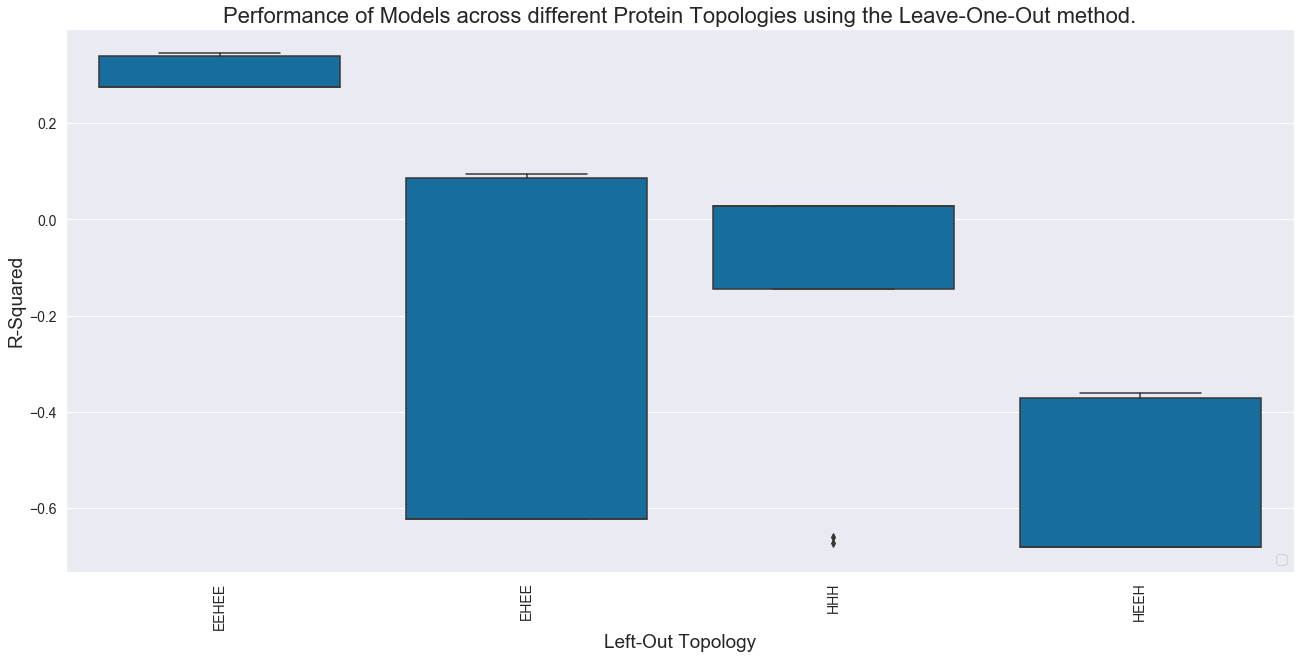

<Figure size 1584x720 with 0 Axes>

In [20]:
vis_boxplot(data_df=loo_df,
            x_colname="tested_topology", y_colname="R-Squared",
            x_label="Left-Out Topology", y_label="R-Squared",
            title="Performance of Models across different Protein Topologies using the Leave-One-Out method.", 
            color_by_col="Model Name")